In [4]:
%load_ext autoreload
%autoreload 2

from mcmc import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import csv
import pandas as pd
import powerlaw
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
with open('Data/DTI_avg.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    data = list(reader)
DTI = pd.DataFrame(data, dtype = 'float64')
dti_c_matrix = DTI.values
dti_c_matrix /= np.max(dti_c_matrix)

## Fitting a powerlaw

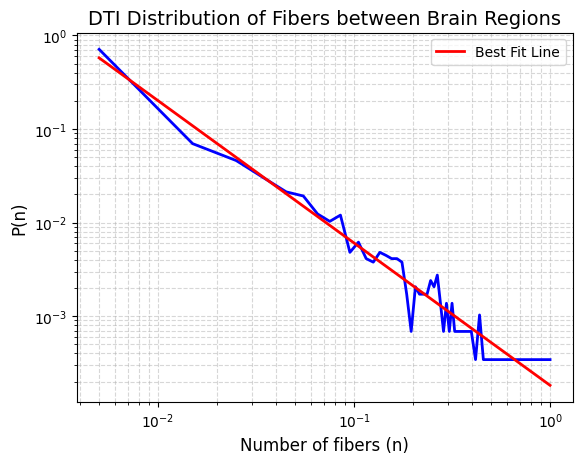

Best-fit parameters: a = -1.5223545238102074 b = -3.7419298059164476
Calculating best minimal value for power law fit


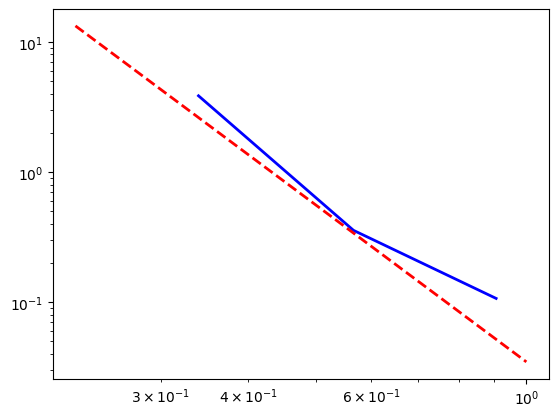

R: 0.0012768402886895597
p: 0.8709889525498042
3.9988601418320138 0.22629806362562094


In [7]:
matrix = dti_c_matrix
n = len(matrix)
value_list = [matrix[i][j] for i in range(n) for j in range(n) if i != j]
value_list = [x for x in value_list if x != 0] 

value_list = np.array(value_list, dtype=np.float64)
hist, bins = np.histogram(value_list, bins= 100)
hist = hist / len(value_list)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Filter out bins with no values
nonzero_mask = hist > 0
hist = hist[nonzero_mask]
bin_centers = bin_centers[nonzero_mask]

plt.plot(bin_centers, hist, linewidth=2, color='b')
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

def linear_func(x, a, b):
    return a * x + b

# Fit the straight line to the logarithmic data
log_bin_centers = np.log10(bin_centers)
log_hist = np.log10(hist)
popt, pcov = curve_fit(linear_func, log_bin_centers, log_hist)

# Plot the best-fit straight line on the log-log plot
plt.plot(bin_centers, 10 ** linear_func(np.log10(bin_centers), *popt),
         'r-', linewidth=2, label='Best Fit Line')

plt.xlabel('Number of fibers (n)', fontsize=12)
plt.ylabel('P(n)', fontsize=12)
plt.title('DTI Distribution of Fibers between Brain Regions', fontsize=14)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('Results/DTI_powerlaw.png', bbox_inches = 'tight')
plt.show()

print("Best-fit parameters: a =", popt[0], "b =", popt[1])


#Actually trying to fit a power law
results = powerlaw.Fit(value_list)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
fig = results.plot_pdf(color='b', linewidth=2)
results.power_law.plot_pdf(ax=fig, color='r', linestyle='--', linewidth=2)
plt.show()
R, p = results.distribution_compare('power_law', 'lognormal')
print("R:", R)
print("p:", p)
print(alpha, xmin)

## Magnetization and susceptibility

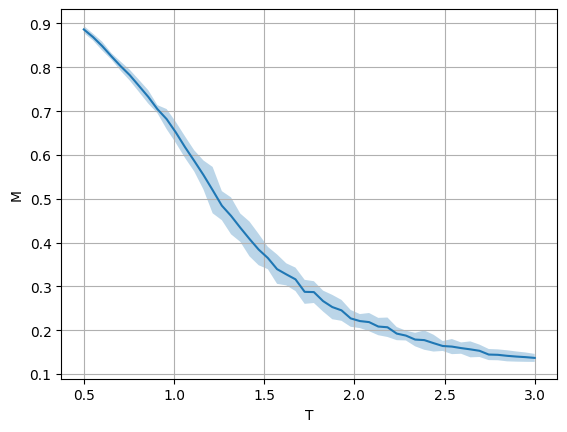

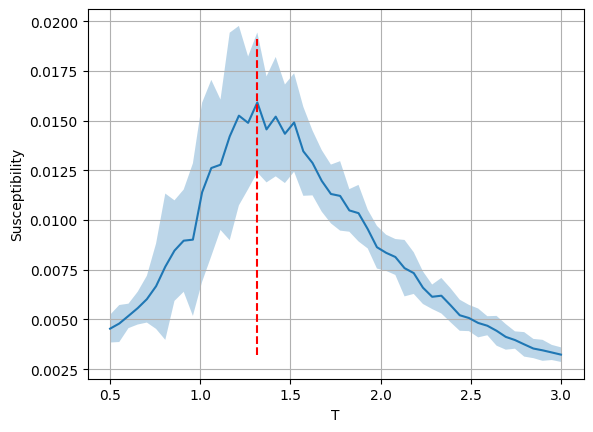

In [3]:
burn_in = 10000
n = 90
temperatures = np.linspace(0.5, 3, 50)
sim_data = run_simulation(20, 20000, temperatures, n, dti_c_matrix, burn_in)
idx = np.argmax(sim_data[2])
temperatures[idx]
plot_results(sim_data, temperatures, 'DTI', save=True)